In [1]:
import torch # library to create multidimentional arrays
import torch.nn.functional as F
import matplotlib.pyplot as plt # to visualize plot
%matplotlib inline

In [2]:
# download the names.txt file from github

!wget https://raw.githubusercontent.com/Raven-SL/ru-pnames-list/master/lists/male_names_rus.txt

--2024-03-02 13:27:29--  https://raw.githubusercontent.com/Raven-SL/ru-pnames-list/master/lists/male_names_rus.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9829 (9.6K) [text/plain]
Saving to: ‘male_names_rus.txt’

male_names_rus.txt  100%[===================>]   9.60K  --.-KB/s    in 0s      

2024-03-02 13:27:29 (60.6 MB/s) - ‘male_names_rus.txt’ saved [9829/9829]



# a. Capitalized
In this part of code, the vocabulary is created according to the dataset, where all the names start with uppercase character, followed by lowercase to train the model, avaluate its performance and generate new words.

In [3]:
words = open('male_names_rus.txt', 'r').read().splitlines()
words[:8]

['Аарон',
 'Аба',
 'Аббас',
 'Абд аль-Узза',
 'Абдуллах',
 'Абид',
 'Аботур',
 'Аввакум']

In [4]:
len(words)

736

In [5]:
# build the vocabulary of characters, uppercase and lowercase, as string to integers and viceversa:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# to print the total number of the characters in vocalubary
len(itos)

62

In [13]:
# to build the dataset:

# to define the context window: the number of characters to take to predict the next character
block_size = 3

# to define a function 'build_dataset' that takes a list of words as input
def build_dataset(words):

  # to start empty lists 'X' and 'Y' to store INPUT pairs
  # 'X' is the INPUT into neural network, 'Y' is Label for each 'X'
  X, Y = [], []

  # to iterate through each word in the INPUT list words
  for w in words:
    # to start a padded context of 0 tokens with length equal to the block_size
    context = [0] * block_size

    # to iterate through each character in the word concatenated with a period (.) indicating the end of the word
    for ch in w + '.': # iterate over all the characters

      # to retrieves the index of the current character 'ch' from a dictionary 'stoi' that maps characters to their corresponding indices
      # to get the characters in a sequence
      ix = stoi[ch]

      # to append the current context to the input list X
      X.append(context)
      # to append the index of the next character to the label list Y
      Y.append(ix)
      # to update the context by removing the first element and adding the index of the current character to the end,
      # to create a rolling window of contexts
      context = context[1:] + [ix]

  # to convert the input list X into a PyTorch tensor
  X = torch.tensor(X)
  # to converts the input list Y into a PyTorch tensor
  Y = torch.tensor(Y)

  # to prints the shapes of X and Y tensors
  print(X.shape, Y.shape)
  # to return X and Y tensor as the output of the 'build_dataset' function
  return X, Y

# to import the 'random' module
import random
# to set the random seed to 42 for reproducibility
random.seed(42)
# to shuffle the list of words randomly
random.shuffle(words)

# to calculate the index n1, which corresponds to 80% of the total number of words
n1 = int(0.8*len(words))
# to calculate the index n2, which corresponds to 90% of the total number of words
n2 = int(0.9*len(words))

# to build the TRAINING dataset (Xtr, Ytr) using the first 80% of the shuffled words (n1)
Xtr, Ytr = build_dataset(words[:n1])

# to build the VALIDATION dataset (Xdev, Ydev) using the next 10% of the shuffled words (n2 - n1)
Xdev, Ydev = build_dataset(words[n1:n2])

# to bugild the TEST dataset (Xte, Yte) using the remaining 10% of the shuffled words (100% - n2)
Xte, Yte = build_dataset(words[n2:])

torch.Size([4211, 3]) torch.Size([4211])
torch.Size([526, 3]) torch.Size([526])
torch.Size([548, 3]) torch.Size([548])


In [15]:
# to initialize parameters for a neural network model:

# to create a random number generator for reproducibility
g = torch.Generator().manual_seed(2147483647)

# to build an INPUT layer, a random tensor C with dimensions (62, 10), where 62 is number of rows (characters in vocabulary) represented by a 10-dim embedding
C = torch.randn((62, 10), generator=g)

# to buld a second layer of random weight matrix W1 with dimensions (30, 200), where 30 neurons are in the HIDDEN layer,
# and each neuron has 200 connections coming from the INPUT layer
W1 = torch.randn((30, 200), generator=g)

# to build random bias vector b1 with 200 elements associated with  200 neurons in the HIDDEN layer
b1 = torch.randn(200, generator=g)

# to build a randon weight matrix W2 with dimensions (200, 62) that connecting the HIDDEN layer to the OUTPUT layer
W2 = torch.randn((200, 62), generator=g)

# to build a random bias vector b2 with 62 elements associated with 62 neurons in the OUTPUT layer
b2 = torch.randn(62, generator=g)

# to collect all the parameters of the neural network model
parameters = [C, W1, b1, W2, b2]

In [16]:
# number of parameters in total
sum(p.nelement() for p in parameters)

19282

In [17]:
# the loop that iterates over all parameters (C, W1, b1, W2, b2) and sets 'requires_grad' attribute to True.
# to indicate that gradients should be computed for these parameters during backpropagation
for p in parameters:
  p.requires_grad = True

In [18]:
# to initialize a learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [11]:
# to create lists to track learning rate, loss, and step (iteration) during the model training
lri = []
lossi = []
stepi = []

In [19]:
# to train the model:

for i in range(200000): # the loop that iterates over 200k training iterations

  # to select randomly 32 indices from the training data (Xtr) for creating a minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass:
  # to look up embeddings from the matrix C based on the randomly selected indices from the training data (Xtr)
  # to create a tensor of shape (32, 3, 2)
  emb = C[Xtr[ix]] # (32, 3, 2)

  # to compute the HIDDEN layer activations using the embeddings, weight matrix W1, and bias vector b1
  # to appliy the tanh function
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)

  # to compute the logits (output of the neural network before applying softmax)
  # to multiply the HIDDEN layer with weight W2 and adding bias b2
  logits = h @ W2 + b2 # (32, 62)

  # to compute the cross-entropy loss between the predicted logits and the true labels (Ytr)
  # it uses built-in cross_entropy function
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass:
  # the loop resets the gradients of all parameters to None before computing gradients for the current minibatch
  for p in parameters:
    p.grad = None

  # to compute gradients of the loss using backpropagation
  loss.backward()

  # to adjust the learning rate setting the higher lr of 0.1 for the first 100k iterations
  # and lower lr of 0.01 for the remaining iterations
  lr = 0.1 if i < 100000 else 0.01

  # the loop to update parameters with gradients and the learning rate
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # to append the current iteration number to the list 'stepi'
  stepi.append(i)

  # to append the logarithm (base 10) of the loss to the list 'lossi'
  lossi.append(loss.log10().item())

In [20]:
# to print out the loss value obtained after the last training iteration (how well the model works)
print(loss.item())

1.111713171005249


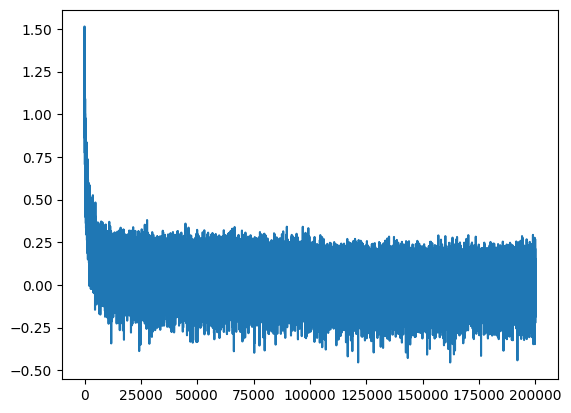

In [21]:
# to plot the training loss over the course of training
# where 'stepi' is the iteration numbers and 'lossi' is the corresponding loss values
plt.plot(stepi, lossi)

In [22]:
# training loss
# to calculate ther trainnig loss by retrieving the embeddings for the training examples (Xtr) from the embedding matrix C
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 62)
# to calculate cross-enthropy loss between the predicted logits and the labels (Ytr)
loss = F.cross_entropy(logits, Ytr)
# to print put the results
loss

tensor(1.0715, grad_fn=<NllLossBackward0>)

In [23]:
# validation loss
# to calculate the validation loss using the same process as the training loss but with the validation dataset (Xdev, Ydev)
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 62)
loss = F.cross_entropy(logits, Ydev)
# to print put the results
loss

tensor(5.8346, grad_fn=<NllLossBackward0>)

In [24]:
# test loss
# to calculate the test loss with the test dataset (Xte, Yte)
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 62)
loss = F.cross_entropy(logits, Yte)
# to print put the results
loss

tensor(5.7648, grad_fn=<NllLossBackward0>)

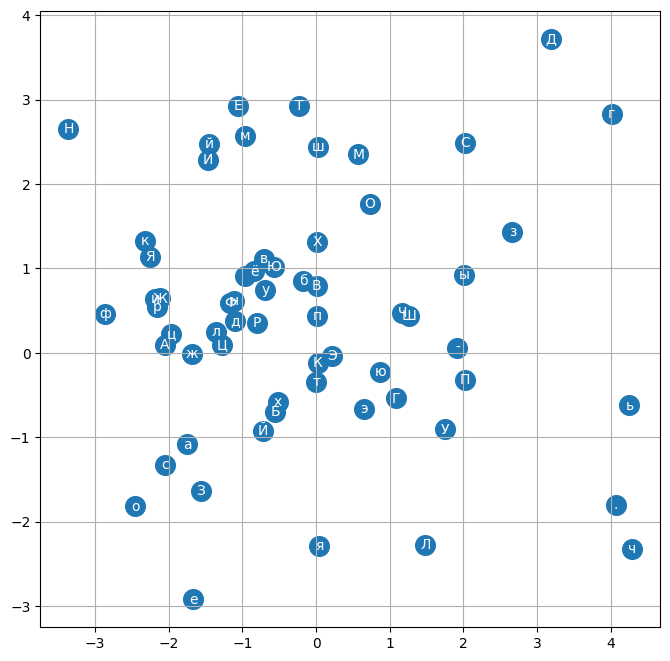

In [25]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8)) # to create a new figure for the plot with size of 8x8 inches

# to creates a scatter plot using the first and second dimensions of the embedding matrix C
# where point in the scatter plot represents the embedding of a character
# the s = 200 argument sets the size of each point to 200
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

# the loop that iterates over each character embedding in the embedding matrix C
for i in range(C.shape[0]):

    # the annotatins to the scatter plot at the position of each character's embedding
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')

# to add a minor grid to the plot
plt.grid('minor')

In [26]:
# Let's sample from the model:

# to create a new random number generator with a specific seed (2147483647 + 10)
# it will be used to ensure reproducibility in the sampling process
g = torch.Generator().manual_seed(2147483647 + 10)

# the loop that iterates 50 times to generate 50 text sequences
for _ in range(50):

    # to initialize an empty list to store the sampled text sequence
    out = []
    # to initialize the context with a list of zeros
    context = [0] * block_size
    # to start an infinite loop to sample text until a termination condition is met
    while True:
      # to retrieve the embeddings for the current context from the embedding matrix C
      emb = C[torch.tensor([context])] # (1,block_size,d)
      # to compute the activations of the HIDDEN layer neurons using the embeddings, weight W1, and bias b1
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      # to calculate the logits by multiplying the HIDDEN layer activations with weight W2 and adding bias b2
      logits = h @ W2 + b2
      # to applie the softmax function along dimension 1 (rows) to convert the logits into probabilities
      probs = F.softmax(logits, dim=1)
      # to sample a single character (index) from the probability distribution defined by probs using the multinomial function to represent the next character in the sequence
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # to update the context by removing the first element and appending the sampled index to the end to prepare the context for the next iteration of sampling
      context = context[1:] + [ix]
      # to append the sampled index to the list of sampled indices
      out.append(ix)
      # the condition to check if the sampled index is the termination token (0) to stop the sampling process
      if ix == 0:
        break
    # to print the sampled text sequence
    # to convert the sampled indices (out) back into characters using the itos list and see the generated results :)
    print(''.join(itos[i] for i in out))

Клаас.
Коррад.
Волом.
Герапит.
Карей.
Дорофаниэль.
Адар.
Евтихий.
Паруйр.
Андр.
Павсикантин.
Натаниэль.
Дитрий.
Шон.
Авдей.
Мамбет.
Терри.
Герасир.
Джейкоб.
Донам.
Эмиль.
Борин.
Людовик.
Тихомин.
Урызмаг.
Полиевкт.
Юстасий.
Пётр.
Марион.
Наил.
Рон.
Владий.
Павлин.
Афиф.
Геромир.
Илладар.
Ашот.
Иоганн.
Сапион.
Гурий.
Генри.
Эстеберт.
Ананий.
Радосей.
Андокид.
Сигеберт.
Гай.
Автон.
Айрат.
Хирам.


# b. Non-capitalized
In this part of code, the same dataset of male names is lowercased to see the difference between performance of the model that is trained on capitalized dataset and the model that is trained on non-capitalized dataset.

In [27]:
# to open and read the file, turn all characters lowercase, and split the string into list:
words = open('male_names_rus.txt', 'r').read().lower().splitlines()

# print out first 8 words
words[:8]

['аарон',
 'аба',
 'аббас',
 'абд аль-узза',
 'абдуллах',
 'абид',
 'аботур',
 'аввакум']

In [28]:
# build the vocabulary of characters as a string to integers and viceversa:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# to print the total number of the characters in vocalubary
len(itos)

34

In [29]:
# to build the dataset:

# to define the context window: the number of characters to take to predict the next character
block_size = 3

# to define a function 'build_dataset' that takes a list of words as input
def build_dataset(words):

  # to start empty lists 'X' and 'Y' to store INPUT pairs
  # 'X' is the INPUT into neural network, 'Y' is Label for each 'X'
  X, Y = [], []

  # to iterate through each word in the INPUT list words
  for w in words:
    # to start a padded context of 0 tokens with length equal to the block_size
    context = [0] * block_size

    # to iterate through each character in the word concatenated with a period (.) indicating the end of the word
    for ch in w + '.': # iterate over all the characters

      # to retrieves the index of the current character 'ch' from a dictionary 'stoi' that maps characters to their corresponding indices
      # to get the characters in a sequence
      ix = stoi[ch]

      # to append the current context to the input list X
      X.append(context)
      # to append the index of the next character to the label list Y
      Y.append(ix)
      # to update the context by removing the first element and adding the index of the current character to the end,
      # to create a rolling window of contexts
      context = context[1:] + [ix]

  # to convert the input list X into a PyTorch tensor
  X = torch.tensor(X)
  # to converts the input list Y into a PyTorch tensor
  Y = torch.tensor(Y)

  # to prints the shapes of X and Y tensors
  print(X.shape, Y.shape)
  # to return X and Y tensor as the output of the 'build_dataset' function
  return X, Y

# to import the 'random' module
import random
# to set the random seed to 42 for reproducibility
random.seed(42)
# to shuffle the list of words randomly
random.shuffle(words)

# to calculate the index n1, which corresponds to 80% of the total number of words
n1 = int(0.8*len(words))
# to calculate the index n2, which corresponds to 90% of the total number of words
n2 = int(0.9*len(words))

# to build the TRAINING dataset (Xtr, Ytr) using the first 80% of the shuffled words (n1)
Xtr, Ytr = build_dataset(words[:n1])

# to build the VALIDATION dataset (Xdev, Ydev) using the next 10% of the shuffled words (n2 - n1)
Xdev, Ydev = build_dataset(words[n1:n2])

# to bugild the TEST dataset (Xte, Yte) using the remaining 10% of the shuffled words (100% - n2)
Xte, Yte = build_dataset(words[n2:])

torch.Size([4206, 3]) torch.Size([4206])
torch.Size([550, 3]) torch.Size([550])
torch.Size([529, 3]) torch.Size([529])


In [30]:
# to initialize parameters for a neural network model:

# to create a random number generator for reproducibility
g = torch.Generator().manual_seed(2147483647)

# to build an INPUT layer, a random tensor C with dimensions (34, 10), where 34 is number of rows (characters in vocabulary) represented by a 10-dim embedding
C = torch.randn((34, 10), generator=g)

# to buld a second layer of random weight matrix W1 with dimensions (30, 200), where 30 neurons are in the HIDDEN layer,
# and each neuron has 200 connections coming from the INPUT layer
W1 = torch.randn((30, 200), generator=g)

# to build random bias vector b1 with 200 elements associated with  200 neurons in the HIDDEN layer
b1 = torch.randn(200, generator=g)

# to build a randon weight matrix W2 with dimensions (200, 34) that connecting the HIDDEN layer to the OUTPUT layer
W2 = torch.randn((200, 34), generator=g)

# to build a random bias vector b2 with 34 elements associated with 34 neurons in the OUTPUT layer
b2 = torch.randn(34, generator=g)

# to collect all the parameters of the neural network model
parameters = [C, W1, b1, W2, b2]

In [31]:
# number of parameters in total
sum(p.nelement() for p in parameters)

13374

In [32]:
# the loop that iterates over all parameters (C, W1, b1, W2, b2) and sets 'requires_grad' attribute to True.
# to indicate that gradients should be computed for these parameters during backpropagation
for p in parameters:
  p.requires_grad = True

In [33]:
# to initialize a learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [34]:
lri = []
lossi = []
stepi = []

In [35]:
# to train the model:

for i in range(200000): # the loop that iterates over 200k training iterations

  # to select randomly 32 indices from the training data (Xtr) for creating a minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass:
  # to look up embeddings from the matrix C based on the randomly selected indices from the training data (Xtr)
  # to create a tensor of shape (32, 3, 2)
  emb = C[Xtr[ix]] # (32, 3, 2)

  # to compute the HIDDEN layer activations using the embeddings, weight matrix W1, and bias vector b1
  # to appliy the tanh function
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)

  # to compute the logits (output of the neural network before applying softmax)
  # to multiply the HIDDEN layer with weight W2 and adding bias b2
  logits = h @ W2 + b2 # (32, 34)

  # to compute the cross-entropy loss between the predicted logits and the true labels (Ytr)
  # it uses built-in cross_entropy function
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass:
  # the loop resets the gradients of all parameters to None before computing gradients for the current minibatch
  for p in parameters:
    p.grad = None

  # to compute gradients of the loss using backpropagation
  loss.backward()

  # to adjust the learning rate setting the higher lr of 0.1 for the first 100k iterations
  # and lower lr of 0.01 for the remaining iterations
  lr = 0.1 if i < 100000 else 0.01

  # the loop to update parameters with gradients and the learning rate
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # to append the current iteration number to the list 'stepi'
  stepi.append(i)

  # to append the logarithm (base 10) of the loss to the list 'lossi'
  lossi.append(loss.log10().item())

In [36]:
# to print out the loss value obtained after the last training iteration (how well the model works)
print(loss.item())

1.3356733322143555


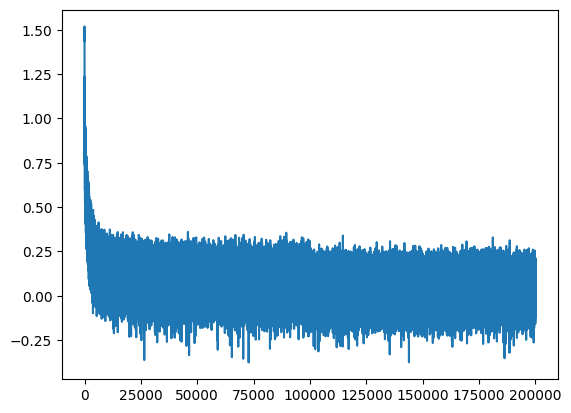

In [37]:
# to plot the training loss over the course of training
# where 'stepi' is the iteration numbers and 'lossi' is the corresponding loss values
plt.plot(stepi, lossi)

In [38]:
# training loss
# to calculate ther trainnig loss by retrieving the embeddings for the training examples (Xtr) from the embedding matrix C
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 34)
# to calculate cross-enthropy loss between the predicted logits and the labels (Ytr)
loss = F.cross_entropy(logits, Ytr)
# to print put the results
loss

tensor(1.1585, grad_fn=<NllLossBackward0>)

In [39]:
# validation loss
# to calculate the validation loss using the same process as the training loss but with the validation dataset (Xdev, Ydev)
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 34)
loss = F.cross_entropy(logits, Ydev)
# to print put the results
loss

tensor(6.3454, grad_fn=<NllLossBackward0>)

In [40]:
# test loss
# to calculate the test loss with the test dataset (Xte, Yte)
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 34)
loss = F.cross_entropy(logits, Yte)
# to print put the results
loss

tensor(6.0265, grad_fn=<NllLossBackward0>)

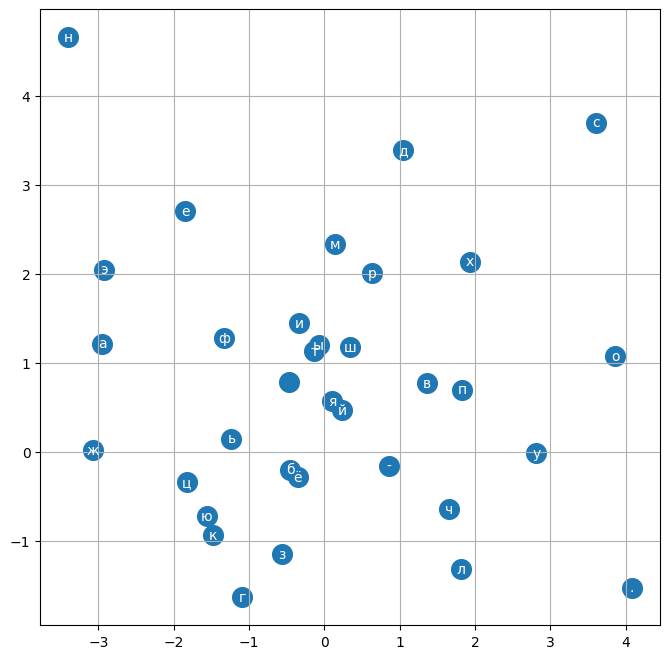

In [41]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8)) # to create a new figure for the plot with size of 8x8 inches

# to creates a scatter plot using the first and second dimensions of the embedding matrix C
# where point in the scatter plot represents the embedding of a character
# the s = 200 argument sets the size of each point to 200
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

# the loop that iterates over each character embedding in the embedding matrix C
for i in range(C.shape[0]):

    # the annotatins to the scatter plot at the position of each character's embedding
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')

# to add a minor grid to the plot
plt.grid('minor')

In [42]:
# Let's sample from the model:

# to create a new random number generator with a specific seed (2147483647 + 10)
# it will be used to ensure reproducibility in the sampling process
g = torch.Generator().manual_seed(2147483647 + 10)

# the loop that iterates 50 times to generate 50 text sequences
for _ in range(50):

    # to initialize an empty list to store the sampled text sequence
    out = []
    # to initialize the context with a list of zeros
    context = [0] * block_size
    # to start an infinite loop to sample text until a termination condition is met
    while True:
      # to retrieve the embeddings for the current context from the embedding matrix C
      emb = C[torch.tensor([context])] # (1,block_size,d)
      # to compute the activations of the HIDDEN layer neurons using the embeddings, weight W1, and bias b1
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      # to calculate the logits by multiplying the HIDDEN layer activations with weight W2 and adding bias b2
      logits = h @ W2 + b2
      # to applie the softmax function along dimension 1 (rows) to convert the logits into probabilities
      probs = F.softmax(logits, dim=1)
      # to sample a single character (index) from the probability distribution defined by probs using the multinomial function to represent the next character in the sequence
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # to update the context by removing the first element and appending the sampled index to the end to prepare the context for the next iteration of sampling
      context = context[1:] + [ix]
      # to append the sampled index to the list of sampled indices
      out.append(ix)
      # the condition to check if the sampled index is the termination token (0) to stop the sampling process
      if ix == 0:
        break
    # to print the sampled text sequence
    # to convert the sampled indices (out) back into characters using the itos list and see the generated results :)
    print(''.join(itos[i] for i in out))

конс.
дар.
борив.
клаас.
кадвалентий.
басий.
мордехай.
евдоким.
виталишерон.
харри.
стасий.
валлюстислав.
еренц.
саллюстантоном.
атанит.
геласир.
дональвестислав.
рамазарий.
лазарио.
тендзин.
уман.
азат.
улдис.
модестофор.
олик.
мефодорж.
артур.
евриил.
амфилий.
мэлор.
никий.
матет.
эрас.
солод.
вито.
кас.
гейдар.
бурхард.
абид.
олег.
ахим.
стефанор.
илат.
сон.
стислав.
безсон.
айдар.
радислам.
адан.
анг.
